# Homework 4 - Getting to know your customers

### Import modules

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import math
from statistics import mode
import seaborn as sns
import regex as re
import random
import itertools
import pickle
import copy
import time
from scipy.stats import iqr
import statistics as stat
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

## 1) Finding Similar Costumers

### 1.1 Set up the Data

In [139]:
data = pd.read_csv('C:/Users\iadig\Desktop\hw4\\bank_transactions.csv')
len(data)

1048567

In [140]:
data.dropna(inplace=True)
len(data)

1041614

#### Customer DOB

In [142]:
# substitue rows with DOB = 1/1/1800 since it does not make any sense with the mode 1/1/(19)89 excluding 1/1/1800

data.loc[data['CustomerDOB'].str.contains('1/1/1800'), 'CustomerDOB'] = '1/1/89'
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'], format='%d/%m/%y')

In [143]:
# Substitute rows with year of birth > 2000 (such as years = 2052 etc), offsetting them by 100 years

data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

#### Transaction Date

In [144]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

#### Transaction Time

In [145]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S')).dt.time

#### Customer Location

In [146]:
# customer location cleaning

data['CustLocation'] = data.CustLocation.str.replace('WEST|EAST|DT|CITY|SOUTH|NORTH', '')
data['CustLocation'] = data['CustLocation'].str.replace('[^\w\s]','')
data['CustLocation'] = data.CustLocation.apply(lambda x: re.sub(r"\b\d+\b *|\b[A-Z]\b *", '', x))
data['CustLocation'] = data.CustLocation.apply(lambda x: re.sub(r'\s*\d+\s*', '', x)) # get rid of numbers
data['CustLocation'] = data.CustLocation.apply(lambda x: re.sub(r'\(.*?\)', '', x)) # get rid of pharentheses
data['CustLocation'] = data.CustLocation.apply(lambda x: re.sub(r'\([^()]*\)', '', x))
data['CustLocation'] = data.CustLocation.apply(lambda x: x.rstrip()) # get rid of white space at the end of location

In [147]:
# keep only last word of location

data['CustLocation'] = data['CustLocation'].apply(lambda x: x.split(' ')[-1])

In [150]:
most_common_locations = list(data.CustLocation.value_counts().head(99).index)
data['CustLocation'] = data['CustLocation'].apply(lambda x: x if x in most_common_locations else 'OTHER')

print(len(list(data.CustLocation.value_counts().index)))

100


### Preprocessed Dataset

In [151]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,1957-04-04,M,OTHER,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-02-08,18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,18:48:24,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0


In [41]:
data.to_csv('data1.csv', index = False)

### 1.2 Fingerprint hashing

In [152]:
data1 = data.copy()

#### New customerID: CustomerDOB + CustGender + CustAccountBalance

In [153]:
# get rid of transactionID, customerID and uniquely identify rows with CustomerDOB, CustGender, CustAccountBalance to get rid of unneccesary rows

data1.drop_duplicates(subset=['CustomerDOB','CustGender', 'CustAccountBalance'], inplace = True)
data1.reset_index(inplace = True)
# now, the new identifier is defined by ['CustomerDOB','CustGender', 'CustAccountBalance')

In [154]:
# get rid of unneccessary columns such as TransactionID and CustomerID

data1.drop(['TransactionID', 'CustomerID', 'index'], axis=1, inplace = True)

### 1.2.1 Binning

#### Transaction Amount

In [156]:
# Transaction amount

m = min(data1['TransactionAmount (INR)'])
M = max(data1['TransactionAmount (INR)'])
median = np.median(data1['TransactionAmount (INR)'])
print("The min is equal to", m)
print("The max is equal to", M)
print("The median is equal to", median)

# since the median is so small compared to the max/2 (362,061), we need to have more bins for the smaller values of Transaction
# amount and larger bins (less bins) for higher transaction amounts

# n_bins = 30
# if we want 30 bins, we allocate 20 to values smaller or equal than the median,
# 10 to values between the median and 5000, 10 for values larger than 10000 (which are rare)

bins_trans = [-1] # to include also 0

# 10 bins for values from 0 to median (554)
for b in range(1, 11):
    bins_trans.append(round((median/10)*b, 1))

# 10 bins for values from 555 and 2000
for b1 in range(700, 2000, 200):
    bins_trans.append(b1)
    
# for values between 2001 and 5000
for b2 in range(2, 6):
    bins_trans.append(1000*b2)
    
    
# for values between 5001 and max
bins_trans.append(10000)
bins_trans.append(100000)
bins_trans.append(M)

print("There are", len(bins_trans), "bins") # 25 bins

# data1['TransactionAmount (INR)'].value_counts(bins = bins, sort = False)

The min is equal to 0.0
The max is equal to 724122.0
The median is equal to 554.0
There are 25 bins


In [157]:
# binning

labels_trans = list(range(1, len(bins_trans)))
labels_trans = ['1_' + str(s) for s in labels_trans]

data1['Trans_bins'] = pd.cut(data1['TransactionAmount (INR)'], bins_trans, labels = labels_trans)

# assign to each customer and then use ordinalencoder to go from bin to value (0-24)

#### Transaction time

In [159]:
data1['TransactionHour'] = pd.to_datetime(data1['TransactionTime'], format='%H:%M:%S').dt.hour

data1['TransactionHour'] = data1['TransactionHour'].apply(lambda x: '2_' + str(x))

#### Transaction date

In [160]:
print("The number of unique transaction dates is only:", len(list(data1.TransactionDate.astype(str).unique())))

The number of unique transaction dates is only: 55


In [161]:
data1['TransactionMonth'] = data1['TransactionDate'].dt.month.astype(str)

#### Customer Date of Birth

In [163]:
print("The number of unique Customer dates of birth is equal to:", len(list(data1.CustomerDOB.unique())))

data1['CustomerDOB'] = data1['CustomerDOB'].astype(str)

In [164]:
# extract only year -> year of birth (day and month in which you were born do not matter)

data1['CustomerYOB'] = data1.CustomerDOB.apply(lambda x: x[:4])

In [167]:
# 10 bins for Years of birth

bins_yob = [1900, 1950, 1960, 1970, 1975, 1980, 1985, 1990, 1995, 2000]

labels_yob = list(range(1, len(bins_yob)))
labels_yob = ['Y_' + str(s) for s in labels_yob]

data1['YOB_bins'] = pd.cut(data1['CustomerYOB'].astype(int), bins_yob, labels = labels_yob)

#### Account Balance

In [168]:
print("The number of unique account balances is equal to:", len(list(data1.CustAccountBalance.unique())))

m = min(data1['CustAccountBalance'])
M = max(data1['CustAccountBalance'])
median = round(np.median(data1['CustAccountBalance']), 1)
print("The min is equal to", m)
print("The max is equal to", M)
print("The median is equal to", median)

The number of unique account balances is equal to: 160723
The min is equal to 0.0
The max is equal to 115035495.1
The median is equal to 13679.4


In [170]:
# most balances are below 2000, therefore allocate most bins to the smaller values of CustAccountBalance

print("The number of customers with Account Balance below 2000 is:", len(data1[data1['TransactionAmount (INR)'] <= 2000]))
print("The number of customers with Account Balance below 500 is :", len(data1[data1['TransactionAmount (INR)'] <= 500]))

bins_bal = [-1]

# 10 bins for values from 0 to 500
for b in range(1, 11):
    bins_bal.append(round((50)*b, 1))

# 10 bins for values from 501 and 2000
for b1 in range(600, 2200, 200):
    bins_bal.append(b1)
    
# 20 bins for values between 2001 and 30,000
for b2 in range(1, 21):
    bins_bal.append(3000*b2)
    
# 10 bins for values between 30,001 and 500,000
for b3 in range(1, 6):
    bins_bal.append(100000*b3)
    
# 1 bin for values between 500,001 and max
bins_bal.append(M)


print("There are", len(bins_bal), "bins") # 25 bins

# data1['CustAccountBalance'].value_counts(bins = bins, sort = False)

The number of customers with Account Balance below 2000 is: 138548
The number of customers with Account Balance below 500 is : 81569
There are 45 bins


In [171]:
# binning

labels_bal = list(range(1, len(bins_bal)))
labels_bal = ['3_' + str(s) for s in labels_bal]

data1['CustAccountBalance_bins'] = pd.cut(data1['CustAccountBalance'], bins_bal, labels = labels_bal)

# assign to each customer and then use ordinalencoder to go from bin to value (0-23)

### Bin categorical variables

#### CustGender

In [172]:
# There is only one row with customer gender equal to T, so we will substite it with "F"

data1.loc[data1['CustGender'] == "T", 'CustGender'] = 'F'

#### CustLocation

In [173]:
print("The number of unique locations is:", len(list(data1.CustLocation.unique()))) 

# we already pre-processed the location before excercise 1

The number of unique locations is: 100


### 1.2.2 Shingles

In [176]:
data1.drop(['CustAccountBalance', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerDOB', 'TransactionDate', 'CustomerYOB'], axis=1, inplace = True)

In [177]:
data1

,CustGender,CustLocation,Trans_bins,TransactionHour,TransactionMonth,YOB_bins,CustAccountBalance_bins
0,F,JAMSHEDPUR,1_1,2_14,2,Y_8,3_24
1,M,OTHER,1_23,2_14,2,Y_2,3_19
2,F,MUMBAI,1_9,2_14,2,Y_9,3_24
3,F,MUMBAI,1_19,2_14,2,Y_4,3_44
4,F,MUMBAI,1_17,2_18,2,Y_7,3_21
...,...,...,...,...,...,...,...
170785,M,THANE,1_12,2_17,9,Y_7,3_41
170786,M,THANE,1_11,2_18,9,Y_6,3_40
170787,F,DELHI,1_4,2_18,9,Y_8,3_24
170788,M,OTHER,1_14,2_18,9,Y_7,3_14


In [178]:
customer_list = data1.values.tolist()
print(len(customer_list))

170790


In [179]:
shingles_YOB = list(data1['YOB_bins'].unique())
shingles_Gen = list(data1['CustGender'].unique())
shingles_Loc = list(data1['CustLocation'].unique())
shingles_AccBalance = list(data1['CustAccountBalance_bins'].unique())
shingles_TransDate = list(data1['TransactionMonth'].unique())
shingles_TransHour = list(data1['TransactionHour'].unique())
shingles_Trans = list(data1['Trans_bins'].unique())

shingles = shingles_YOB + shingles_Gen + shingles_AccBalance + shingles_Loc + shingles_TransDate + shingles_TransHour + shingles_Trans

In [180]:
print(len(shingles))

215


### 1.2.3 One hot encoding

In [181]:
def onehot(customer, shingles):
    return np.array([1 if shingle in customer else 0 for shingle in shingles])

### 1.2.4 Shingles Matrix

* this function computes the shingle matrix, i.e. a sparse matrix of ones and zeroes where *one* indicates whether a shingle is present in the *customer_list*, and *zero* otherwise. Here, we exploit the **one hot encoding** function defined above which takes as input two lists, the customer and the shingles list, and assigns a *one* if the shingle is in the customer (equivalently, if that particular attribute belongs to that customer, for instance, if the customer is male or not) and *zero* otherwise.
* In the end, we obtain a vector of ones and zeroes having *shape (1 x 215)*, where 215 is the length of the shingles list.

In [199]:
def shingles_matrix(shingles, customer_list):
                                            
    mat = np.zeros(len(shingles))
    
    for c in customer_list:
        mat = np.vstack([mat, onehot(c, shingles)])

    mat = np.delete(mat, (0), axis = 0)
    
    return mat

* We define a new *function* named $shingles\_matrix\_complete$ for computing the $shingles\_matrix$ for larger datasets like in our case. The process of calculating the *shingles matrix* may take a lot of time. Therefore, we can divide the dataset into **chunks of 5000 rows** and perform the computations on each chunk separately. In the end, we concatenate the resulting matrices, obtaining the $shingles\_m$ matrix.

In [200]:
def shingles_matrix_complete(shingles, customer_list):
    
    shingles_m = np.zeros(len(shingles), dtype = int)

    
    for i in tqdm(range(0, len(customer_list), 5000)):

        chunk = customer_list[i:i+5000]

        matrix = shingles_matrix(shingles, chunk)
        
        shingles_m = np.vstack([shingles_m, matrix])
    
    
    shingles_m = np.delete(shingles_m, (0), axis=0)
        
    return shingles_m

* In this case, the resulting matrix has shape *(170790, 215)*, where *170790* is the number of unique customers and *215* is the number of unique shingles.

In [537]:
shingles_m = shingles_matrix_complete(shingles, customer_list)

100%|██████████| 35/35 [04:57<00:00,  8.50s/it]


In [538]:
print("The shape of the shingles matrix is:", shingles_m.shape)
print(shingles_m)

The shape of the shingles matrix is: (170790, 215)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [539]:
np.savetxt('shingles_matrix.txt', shingles_m, delimiter = ',')

### 1.2.5 Hash Matrix

* This function takes as inputs the shingles matrix, the shingles list and the chosen number of permutations.
* We *transpose the matrix* in order to have the shingles on the rows and the customers on the columns then, we create a dataframe from the matrix in order to use the **pandas .sample** function which *shuffles* the rows of the df.
* We permutate nperm times the rows of $matrix\_transposed$ (dataframe). Then, for each column, we search for the first row having a $one$ and we save the *index* of that row. This process is done nperm times until we obtain a dataframe of length nperm.
* Finally, we return the resulting matrix and dataframe obtained from the hash matrix itself.

In [128]:
def signature_matrix(matrix, shingles, nperm):
    
    random.seed(123)
    
    # We create the columns names, which represent each customer in the dataset
    # Every customer will be named as C_ + number such as C_1,C_2,...,C_2500,...,C_170186
    
    nums = list(range(len(matrix)))
    columns = ['C_' + str(s) for s in nums]
    
    # we transpose the matrix in order to have the shingles on the rows and the customers on the columns then,
    # we create a dataframe from the matrix in order to use the pandas .sample function which shuffles the rows of the df.
    
    matrix_transposed = pd.DataFrame(matrix.transpose(), index = range(len(shingles)), columns = columns)
    
    # We pre-allocate a matrix of zeroes of shape (len(matrix),)
    sig_matrix = np.zeros(len(matrix), dtype = int)
    
    # we permutate nperm times the rows of matrix_transposed (dataframe)
    # Then, for each column, we search for the first row having a one and we save the index of that row
    # This process is done nperm times until we obtain a dataframe of length nperm.
    
    for i in tqdm(range(nperm)):
        sig_matrix = np.vstack([sig_matrix, list(matrix_transposed.sample(frac = 1, random_state = i).reset_index(drop=True).ne(0).idxmax())])
        # we chose frac = 1, where frac is the fraction of rows we need to consider (in this case we want to look at all of them)
        # .ne(x) looks for the values different from 0
        # .idxmax finds the first index

    sig_matrix = np.delete(sig_matrix, (0), axis = 0)
    
    hash_mat_df = pd.DataFrame(sig_matrix, index = range(1, nperm + 1), columns = columns)
    
    # we return the resulting matrix and dataframe obtained from the hash matrix itself
    
    return hash_mat_df, sig_matrix

* Here, we decide to shuffle the dataset 100 times (*nperm = 100*). Therefore, the resulting $hash\_matrix$ will have *shape (100, 170790)*.

In [129]:
nperm = 100

hash_mat_df, sig_mat = signature_matrix(shingles_m, shingles, nperm)

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [130]:
hash_mat_df

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,...,C_170780,C_170781,C_170782,C_170783,C_170784,C_170785,C_170786,C_170787,C_170788,C_170789
1,10,17,59,59,3,20,20,8,0,8,...,74,1,50,3,3,0,3,3,3,3
2,33,67,33,79,8,30,30,30,8,28,...,14,14,8,13,1,8,14,14,8,14
3,26,10,24,3,26,26,26,10,26,10,...,4,4,10,10,0,10,10,4,10,0
4,40,31,83,25,28,25,62,64,9,9,...,46,46,28,59,0,14,59,46,42,32
5,11,5,11,28,20,22,22,53,3,53,...,90,31,20,11,1,12,12,11,110,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,60,69,18,18,18,59,10,18,2,18,...,9,9,9,9,9,9,9,9,9,9
97,33,50,10,5,8,14,50,7,46,3,...,36,68,47,7,8,46,7,8,8,8
98,12,15,21,79,42,43,17,13,9,13,...,46,20,89,13,9,89,13,42,42,42
99,6,6,6,6,1,26,2,34,4,34,...,53,53,18,1,4,27,27,53,53,31


## 1.3 Locality Sensitive Hashing

### 1.3.1 Pre-process the query (in the same manner as for the customer database)

In [182]:
query_df = pd.read_csv('query_users.csv')

* #### Transaction Amount

In [183]:
query_df['Trans_bins'] = pd.cut(query_df['TransactionAmount (INR)'], bins_trans, labels = labels_trans)

* #### Transaction Time

In [184]:
query_df.TransactionTime = query_df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S')).dt.time
query_df['TransactionHour'] = pd.to_datetime(query_df['TransactionTime'], format='%H:%M:%S').dt.hour
query_df['TransactionHour'] = query_df['TransactionHour'].apply(lambda x: '2_' + str(x))

* #### Transaction Date

In [185]:
query_df.TransactionDate = pd.to_datetime(query_df.TransactionDate)
query_df['TransactionMonth'] = query_df['TransactionDate'].dt.month.astype(str)

* #### Customer DOB

In [186]:
# substitute the birth dates equal to 1/1/1800 with the mode of CustomerDOB (w/out considering 1/1/89)
query_df.loc[query_df['CustomerDOB'].str.contains('1/1/1800'), 'CustomerDOB'] = '1/1/89'

# we transform the column to datetime
query_df['CustomerDOB'] = pd.to_datetime(query_df['CustomerDOB'], format='%d/%m/%y')

# Substitute rows with year of birth > 2000 (such as years = 2052 etc), offsetting them by 100 years
query_df.loc[query_df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query_df.loc[query_df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [188]:
# Instead of considering the whole birth date, we consider only the year of birth (which is an equivalent of the age)
query_df['CustomerYOB'] = query_df['CustomerDOB'].astype(str).apply(lambda x: x[:4])
query_df['YOB_bins'] = pd.cut(query_df['CustomerYOB'].astype(int), bins_yob, labels = labels_yob)

* #### Customer Location

In [189]:
# customer location cleaning

query_df['CustLocation'] = query_df.CustLocation.str.replace('WEST|EAST|DT|CITY|SOUTH|NORTH', '')
query_df['CustLocation'] = query_df['CustLocation'].str.replace('[^\w\s]','')
query_df['CustLocation'] = query_df.CustLocation.apply(lambda x: re.sub(r"\b\d+\b *|\b[A-Z]\b *", '', x))
query_df['CustLocation'] = query_df.CustLocation.apply(lambda x: re.sub(r'\s*\d+\s*', '', x)) # get rid of numbers
query_df['CustLocation'] = query_df.CustLocation.apply(lambda x: re.sub(r'\(.*?\)', '', x)) # get rid of pharentheses
query_df['CustLocation'] = query_df.CustLocation.apply(lambda x: re.sub(r'\([^()]*\)', '', x))
query_df['CustLocation'] = query_df.CustLocation.apply(lambda x: x.rstrip()) # get rid of white space at the end of location

In [190]:
# keep only last word of location and substitue the location with OTHER for locations not in the most_common_locations list defined previously

query_df['CustLocation'] = query_df['CustLocation'].apply(lambda x: x.split(' ')[-1])
query_df['CustLocation'] = query_df['CustLocation'].apply(lambda x: x if x in most_common_locations else 'OTHER')

* #### Account Balance

In [191]:
query_df['CustAccountBalance_bins'] = pd.cut(query_df['CustAccountBalance'], bins_bal, labels = labels_bal)

* #### Pre-processed query df

In [195]:
query_df.drop(['CustAccountBalance', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerDOB', 'TransactionDate', 'CustomerYOB'], axis=1, inplace = True)

In [196]:
query_df.head(10)

,CustGender,CustLocation,Trans_bins,TransactionHour,TransactionMonth,YOB_bins,CustAccountBalance_bins
0,M,DELHI,1_2,2_14,2,Y_5,3_39
1,M,PANCHKULA,1_22,2_12,2,Y_8,3_21
2,M,PATNA,1_10,2_22,10,Y_8,3_21
3,M,CHENNAI,1_13,2_14,8,Y_7,3_37
4,M,GURGAON,1_2,2_23,9,Y_8,3_39
5,M,BANGALORE,1_6,2_19,11,Y_6,3_26
6,F,OTHER,1_1,2_9,8,Y_5,3_24
7,M,MOHALI,1_1,2_20,2,Y_8,3_9
8,M,MOHALI,1_6,2_18,8,Y_7,3_20
9,M,OTHER,1_6,2_14,8,Y_3,3_44


### 1.3.2 Query hashing

In [197]:
query_customer_list = query_df.values.tolist()
len(query_customer_list)

50

In [201]:
query_shingles_m = shingles_matrix(shingles, query_customer_list)
print('The shape of the query shingles matrix is:', query_shingles_m.shape)

The shape of the query shingles matrix is: (50, 215)


* We define the function $query\_hashing$ which exploits the previously defined functions $shingles\_matrix$ and $hash\_matrix$ to process the query dataset in the same manner as the customer database. We set the number of permutations to 100, the same number of permutations used to create the hash matrix from the customer database.

In [203]:
def query_hashing(shingles_query, query_customer_list, nperm = 100):
    
    query_shingles_m = shingles_matrix(shingles_query, query_customer_list)
    
    query_hash_df, query_hash_m = signature_matrix(query_shingles_m, shingles_query, nperm)
    
    return query_hash_df, query_hash_m

In [205]:
query_hash_df, query_hash_m = query_hashing(shingles, query_customer_list, nperm = 100)

100%|██████████| 100/100 [00:00<00:00, 415.63it/s]


In [206]:
query_hash_df

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,...,C_40,C_41,C_42,C_43,C_44,C_45,C_46,C_47,C_48,C_49
1,59,59,42,35,74,8,35,4,3,30,...,3,35,8,4,20,19,35,3,19,50
2,59,35,1,8,14,13,31,6,6,67,...,8,8,77,8,30,8,32,14,24,8
3,4,10,10,10,10,1,34,10,10,3,...,10,10,2,4,10,3,10,3,47,0
4,21,5,0,12,15,9,13,40,42,44,...,31,42,11,42,25,42,8,21,9,42
5,36,20,1,18,110,14,11,53,62,108,...,56,31,17,31,19,99,0,110,18,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,48,26,60,25,9,37,25,34,25,25,...,25,22,1,35,25,8,25,9,37,8
97,1,19,4,26,1,7,26,29,3,26,...,8,26,7,3,26,47,1,1,37,47
98,60,52,57,35,9,13,43,14,42,43,...,42,43,13,14,78,38,6,42,18,89
99,6,20,17,6,4,68,57,34,68,6,...,68,6,69,69,26,15,26,53,14,52


### 1.3.3 LSH

* In order to perform **LSH**, we need to sort the customers from the *customer database* and the *query csv* in **buckets**.
* To do so, we need to choose the number of bands $b$ and, consequently, the number of rows $r$ that goes in each band. It's important that we satisfy the equivalence $nperm = b*r$, where $nperm$ is the total number of rows in the hash matrix. For instance, if $nperm = 100$, we can choose $b = 25$ and $r = 4$ such that $100 = 25*4$.
* The larger $r$ (or equivalently, the smaller $b$), the more discriminant our algorithm becomes, as it is harder (less likely) that any two customers get hashed to the same bucket. In fact, two rows are considered **candidate pairs** if the two rows have at least one band in which all the rows are identical. We give each row $b$ possible chances. So we hash each row to $b$ buckets and see who it matches with.

####  Customer Database Buckets

In [208]:
def create_buckets(hash_df, n_rows):
    
    buckets = {}
    
    
    for customer, customer_hash in hash_df.iteritems():
        customer_hash = list(customer_hash)              # for each customer in customer_list we create a list
                                                         # of nperm (100) values each according to the hash_matrix
            
        # then, for each customer we divide into bands of n_rows 
        
        for i in range(0, len(customer_hash), n_rows):
            band = tuple(customer_hash[i:i + n_rows])
            
            if band not in buckets:
                buckets[band] = [customer]
            else:
                if customer not in buckets[band]:
                    buckets[band].append(customer)
                
    return buckets

In [352]:
t = time.time()
customer_db_buckets = create_buckets(hash_mat_df, n_rows = 4)
print("It took", round(time.time()-t, 2), "seconds to create the buckets")

It took 22.25 seconds to create the buckets


####  Query Buckets

In [297]:
query_buckets = create_buckets(query_hash_df, n_rows = 4)

#### Check for different thresholds

The **threshold** $t$ is a function of $b$ and $r$.
* We need to pick $b$, $r$ such that $nperm = n*r$.
* The threshold $t$ is approximately equal to $(1/b)^{(1/r)}$.
* For instance, by choosing $b = 25$ and $r = 4$ $\to$ $t = \frac{1}{25}^{\frac{1}{4}} = 0.45$
* By increasing $r$ and decreasing $b$, we increase the number of indeces $r$ (numbers) that need to match for two customers to be assigned to the same bucket and we decrease the number of chances $b$ of that happening.
* **The larger the threshold, the lower the probability of any two customers of being hashed to the same bucket**. Therefore, if we wish to avoid *false positives*, we need to choose a higher threshold. On the other hand, if avoidance of *false negatives* is important, we need to choose $r$ and $b$ such that we obtain a lower threshold.
* It can be seen that, if we increase the threhold, many buckets are composed of only 1 customer, as opposed to what we would obtain with a low threshold where many customers are hashed to the same bucket.

In [114]:
nperm = 100
b = 50
r = 2
t = (1/b)**(1/r)
print(t)

0.1414213562373095


In [113]:
nperm = 100
b = 25
r = 4
t = (1/b)**(1/r)
print(t)

0.4472135954999579


In [116]:
nperm = 100
b = 5
r = 20
t = (1/b)**(1/r)
print(t)

0.9226808345905884


#### Plot

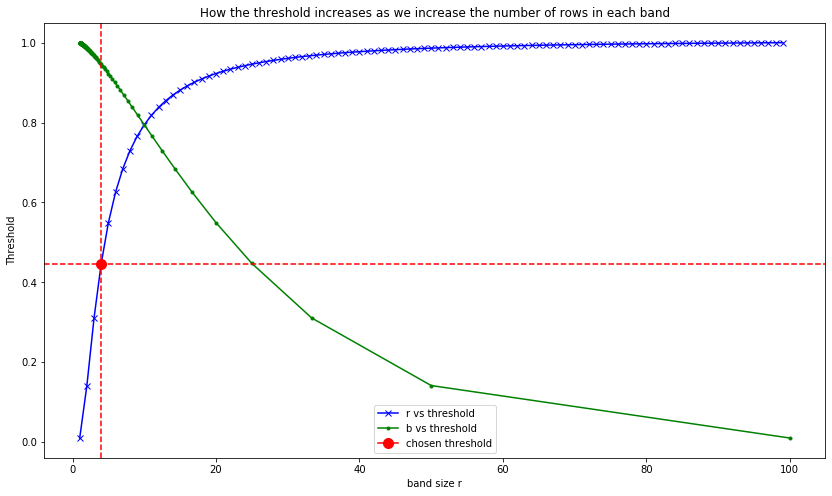

In [26]:
band_size = list(range(1, 100)) 
b = [100/r for r in band_size]
threshold = [(r/100)**(1/r) for r in band_size]

from matplotlib import pyplot as plt

plt.figure(figsize=(14,8))
plt.plot(band_size, threshold, 'bx-', color = 'blue', label = 'r vs threshold')
plt.plot(b, threshold, '.-', color = 'green', label = 'b vs threshold')
plt.axvline(x = 4, color = 'r', linestyle = 'dashed')
plt.axhline(y = 0.447, color = 'r', linestyle = 'dashed')
plt.plot(4, 0.447, marker="o", markersize=10, color = "red", label = 'chosen threshold')
plt.legend()
plt.xlabel('band size r')
plt.ylabel('Threshold')
plt.title('How the threshold increases as we increase the number of rows in each band')
plt.show()

#### LSH and Jaccard Similarity

* From the chosen number of bands *(25)*, we get that the number of $common\_bands$ between the $query\_buckets$ and the $customer\_db\_buckets$ is equal to **1104**.
* The number of buckets in $query\_buckets$ is equal to *1222*. While the length of $customer\_db\_buckets$ is equal to *1090639*.
* By decreasing the number of bands (and therefore, rendering the LSH algorithm more discriminant), we obtain that the number of $common\_bands$ is around *750*, which makes sense.

In [299]:
common_bands = set(query_buckets).intersection(set(customer_db_buckets))
len(common_bands)

1104

* Once we know which are the bands that query customers and the 170790 customers in the customer database have in common, we can find the list of customers (i.e., the **bucket**) to which our algorithm has hashed each query customer.
* We created a dictionary named $result$ where the keys are the ids representing the query customers (C_0,C_1,...,C_49) and the values are sets of (or equivalently, lists of unique) customers that should be similar to the query customer.

In [300]:
result = {}

for band in common_bands:
    for customer in query_buckets[band]:
        if customer not in result:
            result[customer] = copy.deepcopy(customer_db_buckets[band])
        else:
            if customer_db_buckets[band] not in result[customer]:
                result[customer] += customer_db_buckets[band]
                
            
for key in result:
    result[key] = set(result[key])

#### Jaccard similarity

* Let's transpose the shingles matrices and transform them into dataframes. We call them $shingles\_matrix\_tr$ and $query\_matrix\_tr$, where the first is the transposed shingles matrix originated from the customer database and the latter is the transposed shingles matrix originated from the query csv.

In [82]:
shingles_m = np.loadtxt(open('shingles_matrix.txt', 'rb'), delimiter = ",", skiprows=0)
query_shingles_m = np.loadtxt(open('query_shingles_matrix.txt', 'rb'), delimiter = ",", skiprows=0)

In [218]:
nums = list(range(len(shingles_m)))
columns = ['C_' + str(s) for s in nums]
shingles_matrix_tr = pd.DataFrame(shingles_m.transpose(), index = range(len(shingles)), columns = columns)

nums = list(range(len(query_shingles_m)))
columns = ['C_' + str(s) for s in nums]
query_matrix_tr = pd.DataFrame(query_shingles_m.transpose(), index = range(len(shingles)), columns = columns)

* We define the function $jaccard\_similarity$ that takes as inputs the query customer and any other customer in the $customer\_database$.
* Given the list of indeces of the **ones** (7 for each customer) in the shingles matrix, we calculate the **intersection** between the list of values which represent the query customer and the list of values representing any other customer. Therefore, $0$ $\leq$ $intersection$ $\leq$ $7$.
* In the end we return the $similarity = \frac{intersection}{7}$, where 7 is the length of any of the two lists $query\_idx$, $cust\_indx$.

In [219]:
def jaccard_similarity(query, cust):
    
    query_idx = list(query_matrix_tr[query_matrix_tr[query] == 1].index)
    cust_idx = list(shingles_matrix_tr[shingles_matrix_tr[cust] == 1].index)
    intersection = len(list(set(query_idx).intersection(set(cust_idx))))
    
    return float(intersection/len(cust_idx))

#### Example no.1: *C_12*

* We check if our **LSH algorithm** works well by making a couple of examples.
* First, let's take query customer $C\_12$. We calculate the jaccard similarity between $C\_12$ and every customer belonging to the same bucket. Then, we consider similar only those customers having $jaccard\_similarity$ $> 0.5$.
* We sort the results in descending order according to the jaccard similiarity values.
* The results seem promising as there exist many customers (in the same bucket) that have similarity greater than 0.5. In fact, there even is one customer with similarity equal to 1!
* Fo the chosen threshold, the number of FP is quite high on the one hand, but the number of FN is lower. We should just focus on those customers with similarity greater than 0.5 which, in our case, are still **439 customers**.

In [342]:
results_1 = []
FP = []
for customer in result['C_12']:
    jac = round(jaccard_similarity('C_12', customer), 3)
    if jac > 0.5: 
        results_1.append((customer, jac))
    else:
        FP.append((customer, jac))

results_1.sort(key = lambda x: x[1], reverse = True)

In [343]:
len(results_1) # number of customers with similarity > 0.5

439

In [323]:
print(results_1[0:10])

[('C_135252', 1.0), ('C_142555', 0.714), ('C_142846', 0.714), ('C_112066', 0.714), ('C_126129', 0.714), ('C_112471', 0.714), ('C_117811', 0.714), ('C_82820', 0.714), ('C_107201', 0.714), ('C_115613', 0.714)]


In [317]:
# example: 7 out of 7 shingles are the same

print(list(shingles_matrix_tr[shingles_matrix_tr['C_135252'] == 1].index))
print(list(query_matrix_tr[query_matrix_tr['C_12'] == 1].index))

[6, 10, 42, 76, 162, 168, 196]
[6, 10, 42, 76, 162, 168, 196]


#### Example no.2: *C_40*

In [354]:
results_2 = []
sim = []
FP = []
for customer in result['C_40']:
    jac = round(jaccard_similarity('C_40', customer), 3)
    if jac > 0.5:
        results_2.append((customer, jac))
        sim.append(jac)
    else:
        FP.append((customer, jac))

results_2.sort(key = lambda x: x[1], reverse = True)

In [341]:
len(results_2) # number of customers with similarity > 0.5

1625

In [322]:
print(results_2[0:10])

[('C_107160', 0.857), ('C_111874', 0.857), ('C_136710', 0.857), ('C_82819', 0.857), ('C_133245', 0.857), ('C_87539', 0.857), ('C_132715', 0.714), ('C_87395', 0.714), ('C_111906', 0.714), ('C_142143', 0.714)]


In [335]:
# example: 6 out of 7 shingles (which represent the customer) are the same

print(list(shingles_matrix_tr[shingles_matrix_tr['C_107160'] == 1].index))
print(list(query_matrix_tr[query_matrix_tr['C_40'] == 1].index))

[4, 10, 12, 56, 162, 168, 191]
[4, 10, 12, 67, 162, 168, 191]


# Question 2

### 2.1 Getting your data + feature engineering

In [97]:
CustomerData = pd.read_csv("data1.csv")
GrCustData = pd.DataFrame()

In [567]:
CustomerData

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransDateTime,diff
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,2016-02-08 14:32:07,17794.05
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0,2016-02-08 14:18:58,-25728.31
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,2016-02-08 14:27:12,17415.44
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,2016-02-08 14:27:14,864443.21
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,2016-02-08 18:11:56,4951.93
...,...,...,...,...,...,...,...,...,...,...,...
1041609,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,18:48:24,799.0,2016-09-18 18:48:24,6836.19
1041610,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0,2016-09-18 18:37:34,26851.42
1041611,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0,2016-09-18 18:33:13,220987.06
1041612,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0,2016-09-18 18:47:06,9117.87


#### a) Number of transactions

In [557]:
GrCustData["NumTrans"] = CustomerData.groupby(by="CustomerID").size().reset_index(name='NumTrans').NumTrans

#### b) Number of transactions with a balance bigger than 100 USD

In [558]:
GrCustData['NumTransgt100'] = CustomerData.groupby('CustomerID')['CustAccountBalance'].apply(lambda x: (x > 100).sum()).reset_index(name='NumTransgt100').NumTransgt100

#### c) Average amount of the transactions

In [562]:
GrCustData['AvgTrans'] = CustomerData.groupby(by="CustomerID")['TransactionAmount (INR)'].mean().reset_index(name='AvgTrans').AvgTrans

#### d) Average balance

In [559]:
GrCustData['AvgBalance'] = CustomerData.groupby(by="CustomerID")['CustAccountBalance'].mean().reset_index(name='AvgBalance').AvgBalance

#### e) Average difference between the balance and the transaction amount for each customer (Utilisation)

In [560]:
CustomerData['diff'] = CustomerData['CustAccountBalance'] - CustomerData['TransactionAmount (INR)']
GrCustData['Avgdiff'] = CustomerData.groupby(by="CustomerID")['diff'].mean().reset_index(name='Avgdiff').Avgdiff

#### f) Most common gender of the customer

In [564]:
GrCustData['CommGender'] = CustomerData.groupby(by="CustomerID")['CustGender'].apply(lambda x: x.mode().iat[0]).reset_index(name='CommGender').CommGender

#### g) Most frequent location of the customer

In [593]:
GrCustData['CommLocation'] = data1.groupby(by="CustomerID")['CustLocation'].apply(statistics.mode)

### 20 additional features

#### 1. Min transaction amount

In [574]:
GrCustData['MinTransaction'] = CustomerData.groupby(by="CustomerID")["TransactionAmount (INR)"].min().reset_index(name='MinTransaction').MinTransaction

#### 2. Max transaction amount

In [420]:
GrCustData['MaxTransaction'] = CustomerData.groupby(by="CustomerID")["TransactionAmount (INR)"].max().reset_index(name='MaxTransaction').MaxTransaction

#### 3. Sum transaction amount

In [422]:
GrCustData['SumTransaction'] = CustomerData.groupby(by ='CustomerID')['TransactionAmount (INR)'].sum().reset_index(name='SumTransaction').SumTransaction

#### 4. Median transaction amount

In [424]:
GrCustData['MedianTransaction'] = CustomerData.groupby(by ='CustomerID')['TransactionAmount (INR)'].median().reset_index(name='MedianTransaction').MedianTransaction

#### 5. Mean of Sqrt of amount transactions

In [426]:
CustomerData['SqrtTransactions'] = np.sqrt(CustomerData['TransactionAmount (INR)'])
GrCustData['SqrtAvgTrans'] = CustomerData.groupby(by="CustomerID")['SqrtTransactions'].mean().reset_index(name='SqrtAvgTrans').SqrtAvgTrans

#### 6. Mean of Sqrt of balance

In [428]:
CustomerData['SqrtAccBalance'] = np.sqrt(CustomerData['CustAccountBalance'])
GrCustData['SqrtAvgBalance'] = CustomerData.groupby(by="CustomerID")['SqrtAccBalance'].mean().reset_index(name='SqrtAvgBalance').SqrtAvgBalance

#### 7. Balance > 1000

In [ ]:
GrCustData['NumTransgt1000'] = CustomerData.groupby(by ='CustomerID')['CustAccountBalance'].apply(lambda x: (x > 1000).sum()).reset_index(name='NumTransgt1000').NumTransgt1000

#### 8. Balance > 500

In [432]:
GrCustData['NumTransgt500'] = CustomerData.groupby(by ='CustomerID')['CustAccountBalance'].apply(lambda x: (x > 500).sum()).reset_index(name='NumTransgt500').NumTransgt500

#### 9. Most common month

In [476]:
CustomerData['month'] = pd.DatetimeIndex(CustomerData['TransactionDate']).month
GrCustData['CommMonth'] = CustomerData.groupby('CustomerID')['month'].agg(lambda x:x.value_counts().index[0]).reset_index(name='CommMonth').CommMonth

#### 10. Average monthly number of transactions per CustomerID

In [ ]:
GrCustData['AvgMonthlyNumtrans'] = CustomerData.groupby(["CustomerID","month"])['TransactionAmount (INR)'].count().mean(level=0).reset_index(name='AvgMonthlyNumtrans').AvgMonthlyNumtrans

#### 11. Age 

In [494]:
df = pd.DataFrame()
# 1) Create dataframe with customerID and most recent transaction date (df)
df = CustomerData.groupby(by="CustomerID")["TransactionDate"].max().reset_index()
# 2) Create other dataframe with customerID and DOB. (df_CustomerData)
df_CustomerData = CustomerData[["CustomerID", "CustomerDOB"]]
# 3) Inner join on CustomerID, to exclude rows that are not in df. Resulting dataframe has CustomerDOB and most recent CustomerDOB. 
df1 = pd.merge(df, df_CustomerData, how='inner', on='CustomerID')
# 4) Get age by substrascting CustomerDOB from TransactionDate.
df1['CustomerDOB'] = pd.to_datetime(df1['CustomerDOB'])
df1['TransactionDate'] = pd.to_datetime(df1['TransactionDate'])
GrCustData['Age'] = np.rint((df1['TransactionDate'] - df1['CustomerDOB']) / np.timedelta64(1, 'Y'))

#### 12. Is age > 40 
Creation of a binary variable: 1 if the customer is at least 41 years old, 0 otherwise.

In [501]:
GrCustData["Over40"] = np.where(GrCustData['Age'] > 40, 1, 0)

#### 13. Most common weekday

In [505]:
CustomerData['TransactionDate'] = pd.to_datetime(CustomerData['TransactionDate'])
CustomerData['weekday'] = CustomerData['TransactionDate'].dt.dayofweek
GrCustData['CommDay'] = CustomerData.groupby('CustomerID')['weekday'].agg(lambda x:x.value_counts().index[0]).reset_index(name='CommDay').CommDay

#### 14. Most common hour

In [ ]:
CustomerData['TransactionTime'] = pd.to_datetime(CustomerData['TransactionTime'])
CustomerData["TransactionHour"] = CustomerData['TransactionTime'].dt.hour
GrCustData['CommHour'] = CustomerData.groupby('CustomerID')["TransactionHour"].agg(lambda x:x.value_counts().index[0]).reset_index(name='CommHour').CommHour

#### 15. Average transaction frequency (days)
This variable describes for each customer how many days pass by between two transactions on average.  

In [ ]:
CustomerData['days'] = (CustomerData.sort_values('TransactionDate').groupby('CustomerID').TransactionDate.shift() - CustomerData.TransactionDate).dt.days.abs()
CustomerData['days'] = CustomerData['days'].fillna(0)
GrCustData['AvgTransFreqDays'] = CustomerData.groupby(by='CustomerID')['days'].mean().round().reset_index(name='AvgTransFreqDays').AvgTransFreqDays

#### 17. Percentage of transaction against account balance
 What percentage of the total balance represents each transaction amount. If there are multiple observations (transactions) for a single customer, the average is considered.

In [114]:
CustomerData["TransVsBalance"] = CustomerData["TransactionAmount (INR)"]/CustomerData["CustAccountBalance"]
GrCustData['TransVsBalance'] = CustomerData.groupby(by="CustomerID")['TransVsBalance'].mean().reset_index(name='TransVsBalance').TransVsBalance
GrCustData['TransVsBalance'].replace([np.inf, -np.inf], np.nan, inplace=True)
GrCustData['TransVsBalance'] = GrCustData['TransVsBalance'].fillna(0)

#### 18. 25% Percentiles of Amount Transaction 

In [ ]:
GrCustData['FirstQTrans'] = CustomerData.groupby(by="CustomerID")['TransactionAmount (INR)'].quantile(0.25).reset_index(name='FirstQTrans').FirstQTrans

#### 19. 75% Percentiles of Amount Transaction

In [536]:
GrCustData['ThirdQTrans'] = CustomerData.groupby(by="CustomerID")['TransactionAmount (INR)'].quantile(0.25).reset_index(name='ThirdQTrans').ThirdQTrans

#### 20. Number of transactions bigger than 100

In [538]:
GrCustData['NumTransOver100'] = CustomerData.groupby('CustomerID')['TransactionAmount (INR)'].apply(lambda x: (x > 100).sum()).reset_index(name='NumTransOver100').NumTransOver100

Saving the resulting dataframe.

In [10]:
GrCustData.to_csv('Customers.csv', index = False)
Customers = pd.read_csv("Customers.csv")

The resulting dataset has observations relative to each customer, and not to each transaction made by a customer. 
It has 27 features for 879358 different customers IDs.

In [8]:
Customers.head()

,NumTrans,NumTransgt100,AvgTrans,AvgBalance,Avgdiff,CommGender,MinTransaction,MaxTransaction,SumTransaction,MedianTransaction,...,Over40,CommDay,CommHour,AvgTransFreqDays,TransVsBalance,FirstQTrans,ThirdQTrans,NumTransOver100,NumTransOver500,Location
0,2,2,2553.0,76340.635,73787.635,F,356.0,4750.0,5106.0,2553.0,...,0,0,12,9,0.074556,1454.50,1454.50,2,1,NOIDA
1,1,1,1499.0,24204.490,22705.490,M,1499.0,1499.0,1499.0,1499.0,...,0,6,20,0,0.061931,1499.00,1499.00,1,1,MUMBAI
2,2,2,727.5,100112.950,99385.450,F,250.0,1205.0,1455.0,727.5,...,0,4,15,91,0.016472,488.75,488.75,2,1,MUMBAI
3,1,1,30.0,496.180,466.180,F,30.0,30.0,30.0,30.0,...,0,3,17,0,0.060462,30.00,30.00,0,0,OTHER
4,1,1,5000.0,87058.650,82058.650,M,5000.0,5000.0,5000.0,5000.0,...,0,3,14,0,0.057433,5000.00,5000.00,1,1,KOLKATA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879353,1,1,691.0,133067.230,132376.230,M,691.0,691.0,691.0,691.0,...,0,4,0,0,0.005193,691.00,691.00,1,1,OTHER
879354,1,1,222.0,96063.460,95841.460,M,222.0,222.0,222.0,222.0,...,0,3,12,0,0.002311,222.00,222.00,1,0,BANGALORE
879355,1,1,126.0,5559.750,5433.750,M,126.0,126.0,126.0,126.0,...,0,3,12,0,0.022663,126.00,126.00,1,0,GUNTUR
879356,1,1,50.0,35295.920,35245.920,M,50.0,50.0,50.0,50.0,...,0,6,21,0,0.001417,50.00,50.00,0,0,CHENNAI


### 2.2 Choose your features (variables)!

#### a) To normalise or not to normalise? 

* The main reason behind normalization is that we are dealing with a dataset that has variables which are of incomparable units. For example there are some variables that represent frequencies and others that represent amounts of money in a particular currency. Furthermore there are features that show very different variances, that is, they take values in ranges with very different sizes.
* Normalization is also key when performing $PCA$ and $Kmeans$. In particular, leaving variances unequal for $Kmeans$ clustering is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance. 

### PCA preprocessing
#### Features selection
For the principal component analysis only numerical variables will be retained. So columns "Location", "CommDay" and "CommMonth" will be excluded, while variables "CommGender" and "Over40" which are binary will be encoded through one-hot encoding.  

In [21]:
Customers.drop(['Location', 'CommDay', 'CommMonth'], axis=1, inplace = True)

In [12]:
Customers.head()

,NumTrans,NumTransgt100,AvgTrans,AvgBalance,Avgdiff,CommGender,MinTransaction,MaxTransaction,SumTransaction,MedianTransaction,...,AvgMonthlyNumtrans,Age,Over40,CommHour,AvgTransFreqDays,TransVsBalance,FirstQTrans,ThirdQTrans,NumTransOver100,NumTransOver500
0,2,2,2553.0,76340.635,73787.635,F,356.0,4750.0,5106.0,2553.0,...,2.0,24,0,12,9,0.074556,1454.50,1454.50,2,1
1,1,1,1499.0,24204.490,22705.490,M,1499.0,1499.0,1499.0,1499.0,...,1.0,33,0,20,0,0.061931,1499.00,1499.00,1,1
2,2,2,727.5,100112.950,99385.450,F,250.0,1205.0,1455.0,727.5,...,1.0,22,0,15,91,0.016472,488.75,488.75,2,1
3,1,1,30.0,496.180,466.180,F,30.0,30.0,30.0,30.0,...,1.0,24,0,17,0,0.060462,30.00,30.00,0,0
4,1,1,5000.0,87058.650,82058.650,M,5000.0,5000.0,5000.0,5000.0,...,1.0,32,0,14,0,0.057433,5000.00,5000.00,1,1


* Here, we transform the catgorical binary variable "CommGender" to a $(0-1)$ binary variable.

In [22]:
Customers['CommGender'] = np.where(Customers['CommGender'] == "M", 0, 1)
CustomersPCA = Customers
CustomersPCA.head()

,NumTrans,NumTransgt100,AvgTrans,AvgBalance,Avgdiff,CommGender,MinTransaction,MaxTransaction,SumTransaction,MedianTransaction,...,AvgMonthlyNumtrans,Age,Over40,CommHour,AvgTransFreqDays,TransVsBalance,FirstQTrans,ThirdQTrans,NumTransOver100,NumTransOver500
0,2,2,2553.0,76340.635,73787.635,1,356.0,4750.0,5106.0,2553.0,...,2.0,24,0,12,9,0.074556,1454.50,1454.50,2,1
1,1,1,1499.0,24204.490,22705.490,0,1499.0,1499.0,1499.0,1499.0,...,1.0,33,0,20,0,0.061931,1499.00,1499.00,1,1
2,2,2,727.5,100112.950,99385.450,1,250.0,1205.0,1455.0,727.5,...,1.0,22,0,15,91,0.016472,488.75,488.75,2,1
3,1,1,30.0,496.180,466.180,1,30.0,30.0,30.0,30.0,...,1.0,24,0,17,0,0.060462,30.00,30.00,0,0
4,1,1,5000.0,87058.650,82058.650,0,5000.0,5000.0,5000.0,5000.0,...,1.0,32,0,14,0,0.057433,5000.00,5000.00,1,1


* The first step is to scale all variables such that their values are compressed and take only values between 0 and 1

In [25]:
scaler = MinMaxScaler()
norm_df = CustomersPCA[["AvgTrans", "AvgBalance", "Avgdiff", "CommGender", "MinTransaction", "MaxTransaction", "SumTransaction", "MedianTransaction", "SqrtAvgTrans", "SqrtAvgBalance", "NumTransgt1000", "NumTransgt500", "AvgMonthlyNumtrans", "NumTrans", "NumTransgt100", "Age", "CommHour","AvgTransFreqDays", "TransVsBalance", "FirstQTrans", "ThirdQTrans", "NumTransOver100", "NumTransOver500", "Over40"]]
scaler.fit(norm_df)
scaled = scaler.fit_transform(norm_df)
scaled_df = pd.DataFrame(scaled, columns=norm_df.columns)

In [27]:
scaled_df.head()

,AvgTrans,AvgBalance,Avgdiff,CommGender,MinTransaction,MaxTransaction,SumTransaction,MedianTransaction,SqrtAvgTrans,SqrtAvgBalance,...,NumTransgt100,Age,CommHour,AvgTransFreqDays,TransVsBalance,FirstQTrans,ThirdQTrans,NumTransOver100,NumTransOver500,Over40
0,0.001637,0.000664,0.013653,1.0,0.000228,0.003045,0.003273,0.001637,0.035143,0.024565,...,0.333333,0.089109,0.521739,0.053571,1.758488e-08,0.000932,0.000932,0.333333,0.2,0.0
1,0.000961,0.000210,0.013215,0.0,0.000961,0.000961,0.000961,0.000961,0.030998,0.014505,...,0.166667,0.178218,0.869565,0.000000,1.460698e-08,0.000961,0.000961,0.166667,0.2,0.0
2,0.000466,0.000870,0.013873,1.0,0.000160,0.000772,0.000933,0.000466,0.020226,0.027887,...,0.333333,0.069307,0.652174,0.541667,3.885036e-09,0.000313,0.000313,0.333333,0.2,0.0
3,0.000019,0.000004,0.013024,1.0,0.000019,0.000019,0.000019,0.000019,0.004385,0.002077,...,0.166667,0.089109,0.739130,0.000000,1.426056e-08,0.000019,0.000019,0.000000,0.0,0.0
4,0.003205,0.000757,0.013724,0.0,0.003205,0.003205,0.003205,0.003205,0.056613,0.027510,...,0.166667,0.168317,0.608696,0.000000,1.354605e-08,0.003205,0.003205,0.166667,0.2,0.0


#### b) Dimensionality reduction: PCA (only for numerical variables)

The main goal of principal component analysis (PCA) is to capture most of the variance in high-dimensional data within a lower-dimensional subspace. Such subspace is spanned by the first few principal components (normally two or three). 
Therefore it possible to reduce the dimensionionality of the data by selecting a reduced number of principal components to be retained. 

In [ ]:
pca = PCA(len(scaled_df.columns))
principalComponents = pca.fit_transform(scaled_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24'])

In [29]:
principalDf 

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24
0,0.724041,-0.125847,0.112813,0.314170,0.084591,0.196313,0.092873,-0.042539,0.109011,-0.108138,...,-0.000744,-0.002772,0.001178,-0.000010,-2.304684e-04,-0.000043,1.953154e-06,-7.349759e-07,-4.787712e-17,1.678590e-21
1,-0.291323,-0.107923,-0.207381,-0.029964,0.095517,-0.014927,-0.028770,0.043437,-0.012082,-0.003818,...,0.001330,-0.000537,-0.000108,-0.000015,-2.783680e-06,-0.000038,3.651787e-07,3.237845e-07,1.039328e-14,-3.612397e-21
2,0.741596,-0.130045,-0.041427,0.512905,-0.159175,-0.199075,0.000436,-0.063768,-0.049696,-0.041631,...,-0.001602,0.001868,-0.000823,0.000013,3.821009e-05,-0.000073,1.400210e-06,1.009856e-06,6.273372e-19,-2.571366e-23
3,0.685693,-0.126859,-0.003199,-0.309542,-0.092552,-0.079495,-0.003494,-0.042864,0.115690,0.069681,...,-0.000100,0.001524,0.000228,0.000020,3.015179e-05,0.000050,-8.544963e-07,8.686756e-08,-1.012565e-18,2.439308e-21
4,-0.296053,-0.109983,0.049784,0.010460,0.111597,-0.017449,-0.026791,0.033768,-0.018460,-0.007840,...,-0.002192,-0.007507,-0.000376,-0.000066,2.814355e-05,-0.000023,1.489825e-06,1.831059e-07,1.955975e-19,-1.789892e-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879353,-0.307319,-0.109901,0.650599,0.103037,0.137987,-0.020343,-0.018286,0.033864,-0.025389,-0.007155,...,-0.003233,0.003782,-0.000075,0.000015,-1.525971e-05,-0.000052,-3.406869e-07,4.395113e-07,7.087661e-19,-1.310339e-24
879354,-0.303305,-0.112191,0.152204,-0.034730,-0.053657,0.041711,0.044266,0.023630,-0.041399,-0.009894,...,-0.003100,0.001373,0.000195,0.000021,5.081112e-07,0.000022,-7.686120e-08,9.403931e-09,-9.429407e-20,-6.298795e-24
879355,-0.303354,-0.097505,0.152256,-0.035048,-0.054790,0.041243,0.045730,0.091373,-0.039436,-0.006235,...,0.002814,0.001855,0.000173,0.000015,-1.487724e-06,0.000017,-1.715732e-07,4.012122e-08,-5.113290e-19,-1.263004e-23
879356,-0.300263,-0.110262,-0.220468,-0.149502,-0.118101,0.045814,-0.094552,0.034135,0.030996,0.004240,...,-0.000871,0.001004,0.000204,0.000031,1.083448e-05,0.000048,-7.193651e-08,-1.769196e-07,9.177700e-19,3.035514e-24


###### Explained variance ratio

In [32]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([4.75209620e-01, 2.41187008e-01, 1.13460467e-01, 9.51223775e-02,
       2.74893833e-02, 1.95592365e-02, 8.87591845e-03, 6.60723134e-03,
       5.50444782e-03, 2.39713930e-03, 1.53664841e-03, 1.31408722e-03,
       8.29808246e-04, 7.30192998e-04, 9.46958466e-05, 6.58742682e-05,
       9.43474366e-06, 6.03446489e-06, 3.05942810e-07, 8.56199076e-08,
       2.24044362e-09, 2.33801650e-10, 2.83613712e-34, 3.15225044e-41])

###### Correlation matrix

In [30]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.47520962, 0.71639663, 0.8298571 , 0.92497947, 0.95246886,
       0.97202809, 0.98090401, 0.98751124, 0.99301569, 0.99541283,
       0.99694948, 0.99826357, 0.99909337, 0.99982357, 0.99991826,
       0.99998414, 0.99999357, 0.99999961, 0.99999991, 1.        ,
       1.        , 1.        , 1.        , 1.        ])

###### The scree plot
In order to select the best number of principal components to be retained one can resort to the scree plot. It is a line plot representing the eigenvalues of the correlation matrix, plotted in descending order.
If the scree plot contains an "elbow" (a sharp change in the slopes of adjacent line segments), that location might indicate a good number of principal components (PCs) to retain. 

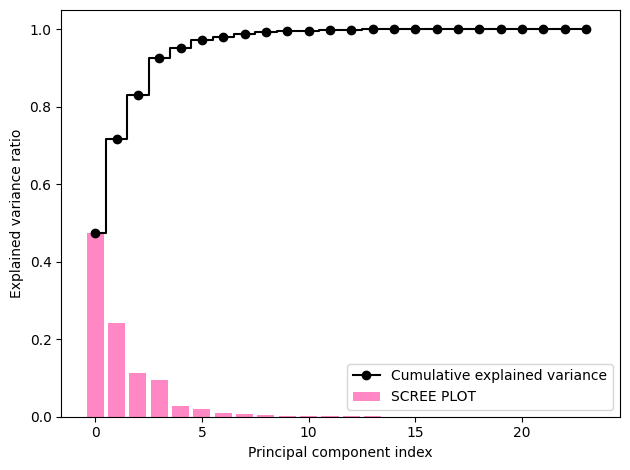

In [31]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, color = 'hotpink', alpha = 0.8, align='center', label='SCREE PLOT')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 'o-', color = 'black', where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

For this example, the scree plot shows a large change in slopes (an elbow) at the second eigenvalue. From the graph of the cumulative proportions, one can see that the first three principal components explain approximately the 83% of the variance in the data, whereas the first four PCs explain 96%. A good method to decide the number of components to be selected is that the total variance explained by the selected components should be greater than 70% of variance. 

#### Limitations of PCA
* Some of the information goes lost, because only few components are retained against the 24 initial features.
* Impossibility to include non-numeric variables, therefore all categorical variables can't be included in the dimensionality reduction process, and information goes lost also under this point of view.
* Risk of overfitting

### 2.3 Clustering

#### Before clustering, let's plot our data accoring to the first three principal components (that explain more than 80% of the variance).
* It looks like there are 4 clusters.

In [38]:
points_df = pd.read_csv('ClusteringData.csv')

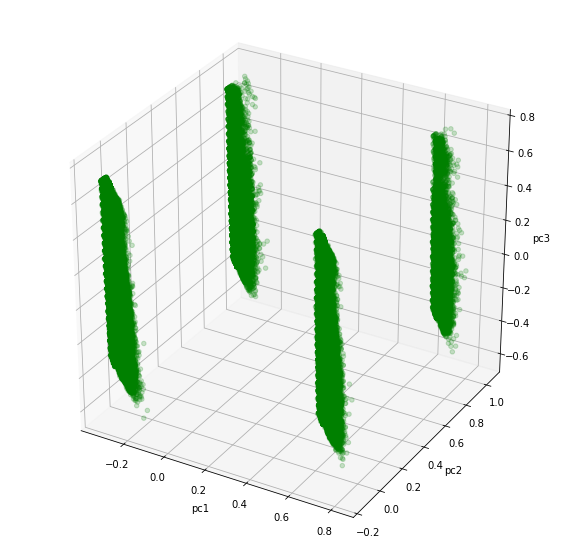

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'], color="green", edgecolors = "green", alpha = 0.2)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

#### Start PySpark Session

In [ ]:
import findspark
import pyspark
from pyspark.sql import SparkSession

In [2]:
findspark.init()
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

#### Read our clustering data (PCs)

In [3]:
data_pca = spark.read.csv('ClusteringData.csv', header = True)

In [4]:
data_pca.show()

+--------------------+--------------------+--------------------+
|                 pc1|                 pc2|                 pc3|
+--------------------+--------------------+--------------------+
|  0.7240411902588979|-0.12584693952924128| 0.11281292421810167|
| -0.2913225612191441|-0.10792259529652737|-0.20738081007050543|
|   0.741595754448062|-0.13004459139530067| -0.0414268192243767|
|  0.6856934925285613|-0.12685859136418834|-0.00319875303902...|
|-0.29605337005942267|-0.10998265458428172|0.049783947581366374|
|  0.6972749358021431|-0.12214586207499828|  0.2936607492771758|
| -0.2747662090816798|   0.907660447692185| 0.12631835424398083|
|-0.25803056784844913|-0.11792617050485728| 0.10597315593492587|
|-0.30567724356384185|-0.11007426514643902| 0.28083915622517275|
|-0.29432656148902264| -0.1183826269871992|-0.03643706269890296|
|  0.6891059692564128|-0.12659001966021766| 0.23767923677948408|
|-0.29774948891246855|-0.10158099576946247| 0.13585113109063482|
|  0.7555284099855144|-0.

### Kmeans with MapReduce

* We read $data\_pca$ and transform every data point into an array, therefore obtaining $rddpca$.

In [5]:
rdd = data_pca.rdd

In [6]:
rddpca = rdd.map(lambda r: np.array(r[0:], dtype = np.float32))

#### The Functions

The first step of the $Kmeans$ algorithm consists in **initializing the centroids**.
* We randomly select $k$ points from our dataset, without replacement (set to *False*) and setting the seed equal to 123 for reproducibility. To do so, we use the $rdd.takeSample()$ method.

In [7]:
def initial_centroids(k, dataset):
    
    centroids = dataset.takeSample(False, k, 123)
    
    return centroids

* This function $eu\_distance$ calculated the **euclidean distance** between any two points.

In [8]:
def eu_distance(p1, p2):
    
    return np.square(np.sum((p1 - p2)**2))

* $assign\_centroid$ exploits the $eu\_distance$ function to calculate the distance between every point in the dataset and the centroids, and **assigns each point to the closest cluster** (centroid).

In [9]:
def assign_centroid(pr, centroids):
    
    distances = np.zeros(len(centroids)) # pre-allocate the array
    
    # calculate the distance between each point and all of the centroids
    for i, centr in enumerate(centroids):   
        distances[i] = eu_distance(pr, centr)
    
    # assign the point to the closest cluster (centroid)
    assigned_centroid = np.argmin(distances)
    
    return (assigned_centroid, pr)

* This function **updates the centroids** once the clusters are formed.

In [10]:
def update_centroid(points):
    
    return sum(points) / len(points)

*  Then, we impement the function $centroids\_shift$ that gives us the **distance between the old and the new centroids**

In [11]:
def centroids_shift(old_c, new_c):
    
    return sum([eu_distance(old_c[i],new_c[i]) for i in range(len(old_c))])

* Function $get\_error$ returns the distance (error) of each point to its closest centroids. We can use this to calculate the **wcss**.

In [12]:
def get_error(pr, centroids):
    
    distances = np.zeros(len(centroids))
    
    for i, centr in enumerate(centroids):   
        distances[i] = eu_distance(pr, centr)
        
    assigned_centroid = np.argmin(distances)
    
    distance = distances[assigned_centroid] # distances of each data point to its closest centroid 
 
    return distance

#### The algorithm

$Kmeans$ is implemented according to the following steps:
1. First, we initialze the centroids, which are chosen at random.
2. Then, we assign each data point to the closest centroid, hence forming k clusters.
3. We recompute the centroids according to the already formed clusters.
4. We repeat steps 2-3 until we manage to minimize the wcss (within cluster sum of squares) for that specific value of k. The algorithm converges and we stop the clustering process.
5. We return the $centroids$, the $assigned\_centroid\_list$, $data$ and $wcss$.

In [13]:
def make_clusters(rddpca, k):
    
    threshold = 0.3
    
    # we sample the first k centroids
    centroids = initial_centroids(k, rddpca)
    
    # we use the map function to assign the points to the nearest centroids
    dist = rddpca.map(lambda r: assign_centroid(r, centroids))
    
    # we use the groupByKey function to obtain the new centroids
    new_centroids = dist.groupByKey().mapValues(lambda x: update_centroid(x)).map(lambda a: a[1]).collect()
    
    # we update the centroids
    update = centroids_shift(centroids, new_centroids)
    centroids = new_centroids
    
    # we repeat the process until the distance between the old and the new centroids is bigger than the threshold we select
    while update > threshold:
        dist = rddpca.map(lambda r: assign_centroid(r, centroids))
        new_centroids = dist.groupByKey().mapValues(lambda x: update_centroid(x)).map(lambda a: a[1])
        update = centroids_shift(centroids, new_centroids.collect())
        centroids = new_centroids.collect()
        
    d = dist.collect()
    assigned_centroid_list = [d[i][0] for i in range(len(d))] # collect the list of centroid assignment (0 to k-1)
    data = [d[i][1] for i in range(len(d))] # data points
    errors = rddpca.map(lambda r: get_error(r, centroids)).collect() # distances of each data point to its closest centroid 
    wcss = sum([i**2 for i in errors]) # sum of squared distances --> WCSS (within cluster sum of squares)

    return centroids, assigned_centroid_list, data, wcss

#### Test for different values of K

* We run $make\_clusters$ for different values of $k$ 1 to 10, to find the optimal number of clusters $k$.

In [14]:
errors = []
data_list = []
centroid_list = []
k_list = []
clusters_list = []

t = time.time()
for k in tqdm(range(1, 11)):
    centroids, assigned_centroid_list, data, wcss = make_clusters(rddpca, k)
    errors.append(wcss)
    data_list.append(data)
    centroid_list.append(centroids)
    clusters_list.append(assigned_centroid_list)
    k_list.append(k)
    
print("It took", time.time() - t, "seconds to run 10 times")

100%|██████████| 10/10 [1:30:12<00:00, 541.27s/it]

It took 5412.730968952179 seconds to run 10 times


In [34]:
df_assigned_clusters = pd.DataFrame({'k1': clusters_list[0], 'k2': clusters_list[1],
                                     'k3': clusters_list[2], 'k4': clusters_list[3],
                                     'k5': clusters_list[4], 'k6': clusters_list[5],
                                     'k7': clusters_list[6], 'k8': clusters_list[7],
                                     'k9': clusters_list[8], 'k10': clusters_list[9]})

In [26]:
df_wcss = pd.DataFrame(errors, columns = ['wcss'])

In [36]:
df_wcss.to_csv('df_wcss.csv', index=False)
df_assigned_clusters.to_csv('df_assigned_clusters.csv', index = False)

### Kmeans++

While in our k-means implementation we can choose the centroids only once at random, with the $sklearn$ k-means++ implementation there are 25 initial choices of random centroids from which we can choose the best (n_init=25).

In [39]:
from sklearn.cluster import KMeans

errors_sk = []
labels = []

t = time.time()

for i in range(1, 11):
    
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=25, max_iter=300, 
        tol=1e-04, random_state=0
    )
    
    km.fit(points_df)
    errors_sk.append(km.inertia_)
    labels.append(km.labels_)

print("It took", time.time() - t, "seconds to run 10 times")

It took 172.13294339179993 seconds to run 10 times


### Difference between k-means with MapReduce and k-means++

The most important difference between the map reduce $k-means$ and the $k-means$++ concerns the different method to choose the initial centroids. In the first case, we choose them by randomly sampling from our data, while in the second case the algorithm takes one centroid at random and then chooses the others in order to have the greatest possible distance between them. In this way, we obtain clusters that far apart from eache other, so it's easier to assign each point to its respective cluster and there should be less cases of point assigned to the wrong cluster. 

### The Elbow method

#### Kmeans with MapReduce

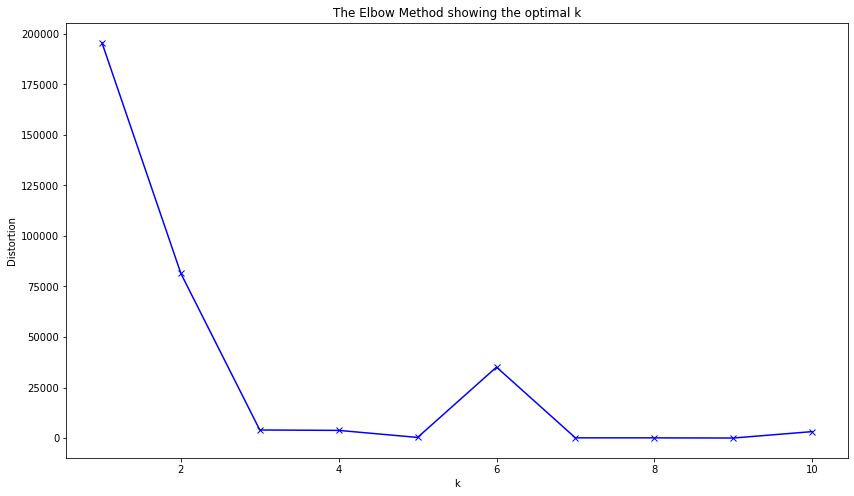

In [15]:
plt.figure(figsize=(14,8))
plt.plot(k_list, errors, 'bx-', color='blue')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Kmeans++

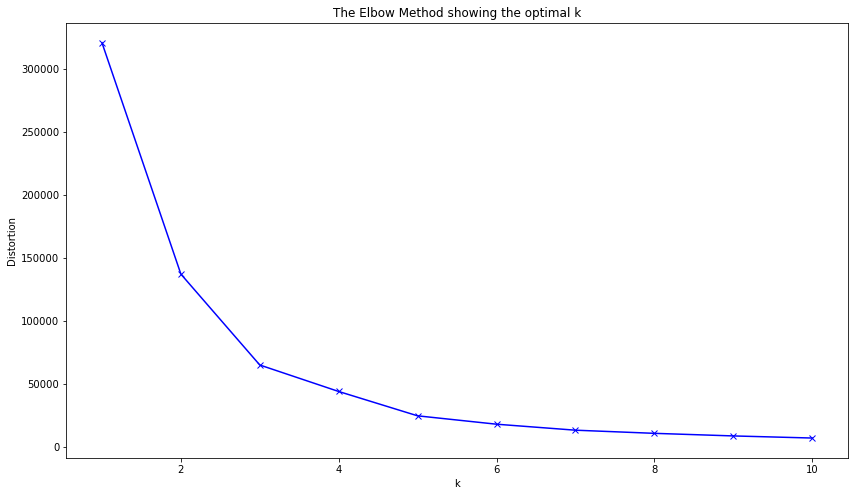

In [40]:
plt.figure(figsize=(14,8))
plt.plot(k_list, errors_sk, 'bx-', color='blue')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The two plots above shows us the result of the possible k values obtained by k-means with mapreduce and by k-means++. $k=3,4,5$ are the best options according to the $Elbow method$. More precicely, the "elbow" seems to land on $k = 3$.

### The Silhouette method

#### Kmeans with MapReduce

In order to run the $sklearn.metrics.silhouette\_score$ we created a sample of 100,000 data points as running it on the whole dataset was too computationally expensive for our resources.

The silhoutte score ranges from $-1$ to $1$:
* $1$ : clusters are well apart from each other and clearly distinguished.
* $0$ : clusters are indifferent, or we can say that the distance between clusters is not significant.
* $-1$: clusters are assigned in the wrong way.

* $K = 3$

In [66]:
import random
sample_df = points_df.copy()
sample_df['cluster_k3'] = df_assigned_clusters['k3']
sample_df['cluster_k4'] = df_assigned_clusters['k4']
sample_df['cluster_k5'] = df_assigned_clusters['k5']
random.seed(123)
sample_df = sample_df.sample(100000).reset_index()

In [67]:
from sklearn.metrics import silhouette_score
score = silhouette_score(sample_df[['pc1', 'pc2', 'pc3']], sample_df['cluster_k3'], metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.728


* $K = 4$

In [68]:
score = silhouette_score(sample_df[['pc1', 'pc2', 'pc3']], sample_df['cluster_k4'], metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.671


* $K = 5$

In [69]:
score = silhouette_score(sample_df[['pc1', 'pc2', 'pc3']], sample_df['cluster_k5'], metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.645


Here, the highest $Silhouette\_score$ has been given by $k = 3$.

### Plot the clusters

#### Kmeans with MapReduce

* $K = 3$

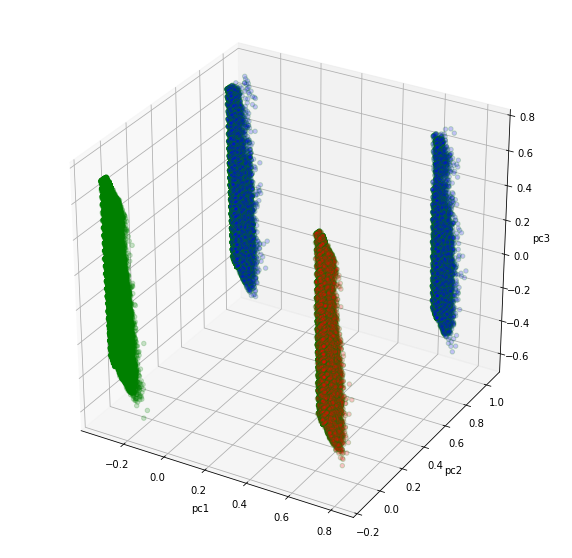

In [46]:
clusters = pd.DataFrame({'clusters': list(clusters_list[2])}) # get the 3rd value
colors = {0:'red', 1:'green', 2:'blue'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

* $K = 4$

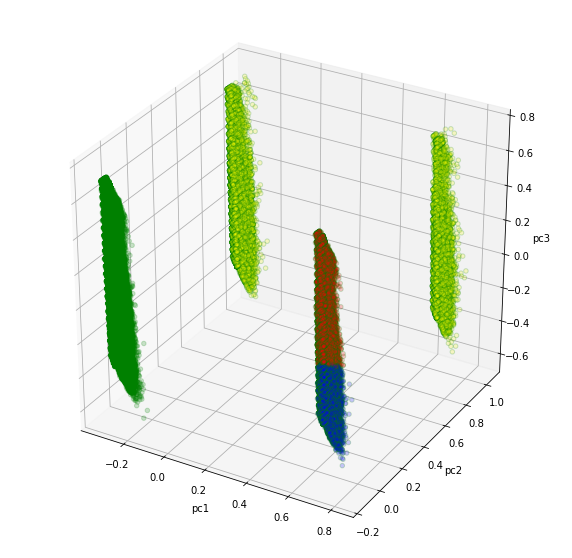

In [47]:
clusters = pd.DataFrame({'clusters': list(clusters_list[3])}) # get the 4th value
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

* $K = 5$

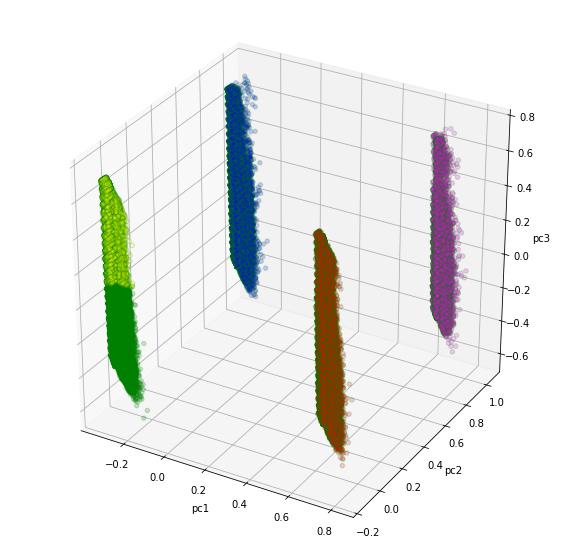

In [49]:
clusters = pd.DataFrame({'clusters': list(clusters_list[4])}) # get the 5Sth value
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'#FF00FF'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

#### Kmeans++

* $K = 3$

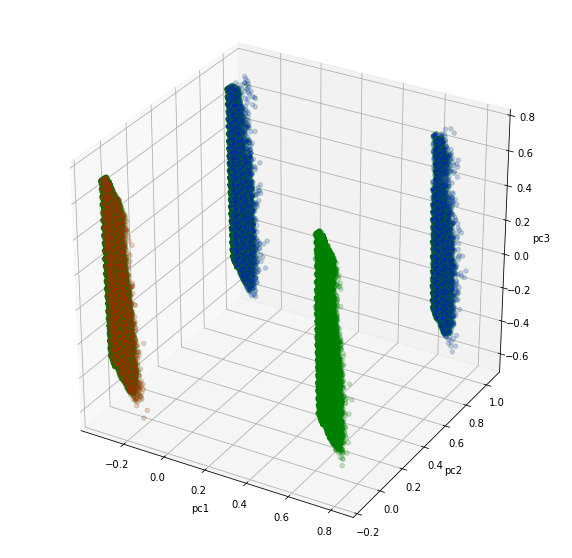

In [50]:
clusters = pd.DataFrame({'clusters': list(labels[2])}) # get the 3rd value
colors = {0:'red', 1:'green', 2:'blue'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

* $K = 4$

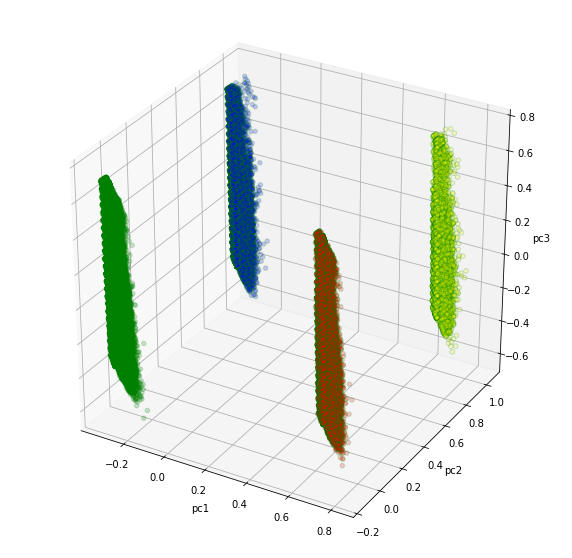

In [51]:
clusters = pd.DataFrame({'clusters': list(labels[3])}) # get the 4th value
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

* $K = 5$

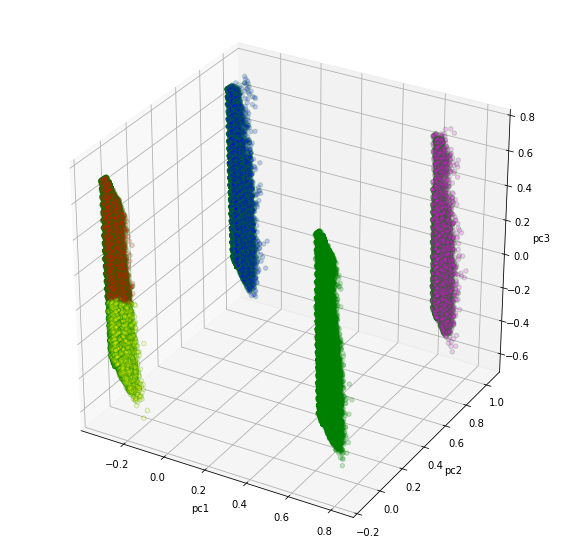

In [52]:
clusters = pd.DataFrame({'clusters': list(labels[4])}) # get the 5th value
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'#FF00FF'} # assign a different color to every cluster

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points_df['pc1'], points_df['pc2'], points_df['pc3'],
           edgecolors = "green", alpha = 0.2, c = clusters['clusters'].map(colors))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

* $Kmeans$ clustering gave very similar results to $kmeans$++ concerning $k=3$ and $k=5$. While for $k=4$ the we obtained clusters that are quite different from one another. In fact, while the results for $kmeans$++ turned out to be what we were expecting in the beginning, for $kmeans$ the resulting clusers are somewhat dissappointing. In our opinion, the latters do no represent good clusters for $K=4$

* In the end, by looking at the $elbow$ $plot$, the $Silhouette\_score$ and the plots above depicting the data and the clusters, we choose $K = 3$.

## 2.4 Analysing the results

In [79]:
Customers = pd.read_csv('Customers.csv')
k3 = pd.read_csv("df_assigned_clusters.csv")

Now we create the dataframe containing only variables which are relevant in order to identify the cluster of the customer

In [47]:
df_2_4 = Customers[['AvgTrans', 'CommGender', 'SumTransaction']]

In [81]:
labels = list(km.labels_)
df_2_4 = df_2_4.assign(cluster = k3["k3"])

### Binning

#### Average Transaction Amount

In [82]:
bins_avgtrans = [-1, 200, 1000, 10000, max(df_2_4['AvgTrans'])]

labels_avgtrans = list(range(4))

df_2_4['AvgTrans_binned'] = pd.cut(df_2_4['AvgTrans'], bins = bins_avgtrans, labels = labels_avgtrans)

#### Sum Transaction Amount

In [83]:
bins_sumtrans = [-1, 200, 1000, 10000, max(df_2_4['SumTransaction'])]

labels_sumtrans = list(range(4))

df_2_4['SumTrans_binned'] = pd.cut(df_2_4['SumTransaction'], bins = bins_sumtrans, labels = labels_sumtrans)

### Pivoting
- Pivoting "AvgTrans_binned"

In [89]:
AvgTrans_binned = df_2_4[['AvgTrans_binned', 'cluster']]
AvgTrans_binned = pd.get_dummies(AvgTrans_binned, prefix=['col1'])
AvgTrans = AvgTrans_binned.groupby(by="cluster").sum()
AvgTrans['Total'] = AvgTrans[["col1_0", "col1_1", "col1_2", "col1_3"]].sum(axis=1)
AvgTrans["AvgTrans0"] = AvgTrans["col1_0"]/AvgTrans['Total']
AvgTrans["AvgTrans1"] = AvgTrans["col1_1"]/AvgTrans['Total']
AvgTrans["AvgTrans2"] = AvgTrans["col1_2"]/AvgTrans['Total']
AvgTrans["AvgTrans3"] = AvgTrans["col1_3"]/AvgTrans['Total']
AvgTrans.drop(['Total', "col1_0", "col1_1", "col1_2", "col1_3"], axis=1, inplace = True)
AvgTrans

,AvgTrans0,AvgTrans1,AvgTrans2,AvgTrans3
cluster,,,,
0,0.237785,0.425286,0.314385,0.022544
1,0.304490,0.418298,0.254796,0.022416
2,0.282457,0.421000,0.274258,0.022285


From the results one can easily note that the distribution of the data is approximately normal, with high tails and is skewed on the left. The fourth bucket is indeed poorly represented, with less than 1% of the observations. Such shape of the data is respected across the 3 different clusters found.
We can see that cluster 0 contains more customers that have an avarage transaction amount which is higher than the other two clusters. Moreover, in the first cluster there are less people in $AvgTrans0$ with respect to the other two clusters.

- Pivoting "SumTrans_binned"

In [86]:
SumTrans_binned = df_2_4[['SumTrans_binned', 'cluster']]
SumTrans_binned = pd.get_dummies(SumTrans_binned, prefix=['col1'])
SumTrans = SumTrans_binned.groupby(by="cluster").sum()
SumTrans['Total'] = SumTrans[["col1_0", "col1_1", "col1_2", "col1_3"]].sum(axis=1)
SumTrans["SumTrans0"] = SumTrans["col1_0"]/SumTrans['Total']
SumTrans["SumTrans1"] = SumTrans["col1_1"]/SumTrans['Total']
SumTrans["SumTrans2"] = SumTrans["col1_2"]/SumTrans['Total']
SumTrans["SumTrans3"] = SumTrans["col1_3"]/SumTrans['Total']
SumTrans.drop(['Total', "col1_0", "col1_1", "col1_2", "col1_3"], axis=1, inplace = True)
SumTrans

,SumTrans0,SumTrans1,SumTrans2,SumTrans3
cluster,,,,
0,0.216254,0.386608,0.366538,0.030600
1,0.290918,0.396738,0.284988,0.027356
2,0.266684,0.394457,0.310906,0.027953


Also in this case, the distribution of the data is skewed towards the left. Similarly to the previous variable, the data in the first cluster appear to have a different shape with respect to the other two clusters, showing a lower tail on the left and in exchange, a higher percentage of observations contained in the third bin. 

In [88]:
df_2_4['CommGender'] = np.where(df_2_4['CommGender'] == "T", "F", df_2_4['CommGender'])
CommGender = df_2_4[['CommGender', 'cluster']]
CommGender = pd.get_dummies(CommGender, prefix=['col1'])
Gender = CommGender.groupby(by="cluster").sum()
Gender['Total'] = Gender[["col1_F", "col1_M"]].sum(axis=1)
Gender["F"] = Gender["col1_F"]/Gender['Total']
Gender["M"] = Gender["col1_M"]/Gender['Total']
#Gender["T"] = Gender["col1_T"]/Gender['Total']
Gender.drop(['Total', "col1_F", "col1_M"], axis=1, inplace = True)
Gender

,F,M
cluster,,
0,1.000000,0.000000
1,0.000000,1.000000
2,0.294925,0.705075


The first cluster (cluster 0) is characterized by the totality of female customers while the second one, (cluster 1) only has male customers. To make a reference to the 3-dimensional plot of the clusters, cluster 0 would the one in red, cluster 1 would be the one in green while the third one is colored in blue in plot. It's the one that contains the most portion of information. Furthermore the third cluster preserves more or less the same proportion of males and females of the one of the entire dataset.

#### Clustering algorithm performance

* In line with the results obtained previously, we think that the choice of k=3 was optimal for our purposes.
* Indeed we can observe that each cluster contains a different category of customers, as it can be clearly seen in the aforementioned plot.
* Through the choice of the combination of these three variables ($AvgTrans$, $SumTrans$, $CommGender$) we achieved a sufficient degree of separation between clusters. In fact, while the first two variables allow to distinguish between the first and the other two clusters, the third variable $CommGender$ makes it possible to separate all three of them.

### Algorithmic Question

In [3]:
l1 = list(map(int, input().split())) #we take in input the number of gates, the number of students and the number of guards
l2 = list(map(int, input().split())) #we take in input the number of the gates associated to each student

def enough_guards (l1, l2):
    G = l1[2] #we call G the numbers of guards taken in input (this will be useful after)
    if G >= len(set(l2)):
        print('YES') #if we take in input more guards than gates, we are sure that there will be enough guards so we print YES, otherwise...
    else:
        gates = {} 
        guards = 0
        result = 'YES'
        for count, gate in enumerate(l2): #... we iterate on the l2 list using enumerate, so that we have also the position of each value
            if gate not in gates:
                gates[gate] = len(l2) - 1 - l2[::-1].index(gate) #we create a dictionary with the gates opened for the first time as keys and the positions of the closure of the gates as associated values of the keys
                guards += 1 #we also add a guard to a counter for each gate we add in the dictionary
            if count-1 in gates.values():
                guards -= 1 #we update the guards counter deleting a guard each time we are right after the position of the closure of a gate, so we obtain the number of necessary guards
            if G < guards:
                result = 'NO' #in the end we print NO if we have in input a number of guards that is minor of the necessary number...
                break
        return result  #... and we print YES otherwise
enough_guards (l1, l2)

 9 14 3
 1 2 3 4 2 1 5 6 5 7 7 8 9 7


YES
